In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn

from mpc.env_dx import frenet_dyn_bicycle, frenet_kin_bicycle  #changed
from mpc.track.src import simple_track_generator, track_functions

import utils_new
import utils

from matplotlib import cm

In [2]:
def plot_sim(x_simulated):
    
    x_list = []
    y_list = []
    
    for i in range(x_simulated.shape[0]):
        xy = utils.frenet_to_cartesian(x_simulated[i,:2], track_coord)
        x_list.append(xy[0].numpy())
        y_list.append(xy[1].numpy())
    
    x_plot = np.array(x_list)
    y_plot = np.array(y_list)
    
    fig, ax = plt.subplots(1,1, figsize=(10,5), dpi=150)
    gen.plotPoints(ax)
    
    custom_cmap = plt.get_cmap('cubehelix').reversed()
    sct = ax.scatter(x_plot, y_plot, c=x_simulated[:,3], cmap=custom_cmap, s=4)
    
    cbar = plt.colorbar(sct)
    cbar.set_label('Velocity') 
    #ax.plot(x_plot, y_plot)
    
    print('x_init: ' + str(gen.xCoords[0]))
    print('y_init: ' + str(gen.yCoords[0]))
    print('yaw_init: ' + str(gen.tangentAngle[0]))
    print('Total Arc Length: ' + str(gen.arcLength[-1]/2))
    plt.show()

In [3]:
mpc_T = 20
mpc_H = 80
n_Q = 10
l_r = 0.10
v_max = 1.5
delta_max = 0.4
pc = 0.2

a_max = 2.0

dx=4
du=2

k_curve = 25
dt = 0.03
l_f = l_r
max_p = 100
track_width = 0.5
track_density = 300
t_track = 0.3

max_track_width_perc = 0.68
bound_d = 0.5*max_track_width_perc*track_width

init_track = [0,0,0]

In [4]:
str_model = f'{mpc_T}_{mpc_H}_{n_Q}_{l_r}_{delta_max}_{v_max}_{pc}'

params = torch.tensor([l_r, l_f, track_width, dt, k_curve, v_max, delta_max, a_max, mpc_T])
params_H = torch.tensor([l_r, l_f, track_width, dt, k_curve, v_max, delta_max, a_max, mpc_H])

In [5]:
gen = simple_track_generator.trackGenerator(track_density,track_width)
track_name = 'DEMO_TRACK'

track_function = {
    'DEMO_TRACK'    : track_functions.demo_track,
    'HARD_TRACK'    : track_functions.hard_track,
    'LONG_TRACK'    : track_functions.long_track,
    'LUCERNE_TRACK' : track_functions.lucerne_track,
    'BERN_TRACK'    : track_functions.bern_track,
    'INFINITY_TRACK': track_functions.infinity_track,
    'SNAIL_TRACK'   : track_functions.snail_track
}.get(track_name, track_functions.demo_track)

track_function(gen, t_track, init_track)
gen.populatePointsAndArcLength()
gen.centerTrack()
track_coord = torch.from_numpy(np.vstack(
    [gen.xCoords,
     gen.yCoords,
     gen.arcLength,
     gen.tangentAngle,
     gen.curvature]))



In [6]:
true_dx = utils_new.FrenetKinBicycleDx(track_coord, params, 'cpu')
control = utils_new.CasadiControl(track_coord, params)

control_H = utils_new.CasadiControl(track_coord, params_H)

9
9


In [7]:
model = utils_new.SimpleNN(mpc_H, n_Q, 3, max_p)
model.load_state_dict(torch.load(f'./models/model_im_{str_model}.pkl'))

<All keys matched successfully>

In [8]:
BS_test = 1

In [9]:
Q_manual = np.repeat(np.expand_dims(np.array([0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0]), 0), mpc_T, 0)
p_manual = np.repeat(np.expand_dims(np.array([0, 0, 0, 0, 0, -0.1, 0, 0, 0, 0]), 0), mpc_T, 0)

Q_manual_H = np.repeat(np.expand_dims(np.array([0, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0]), 0), mpc_H, 0)
p_manual_H = np.repeat(np.expand_dims(np.array([0, 0, 0, 0, 0, -pc, 0, 0, 0, 0]), 0), mpc_H, 0)

idx_to_casadi = [5,1,2,3,8,9]

In [10]:
x0_lap = utils_new.sample_init_test(BS_test, true_dx, sn=0).numpy().squeeze()
x0_lap_pred = x0_lap[:6]
x0_lap_manual = x0_lap[:6]

In [11]:
def eval_lap(x0, Q_manual, p_manual, control, model=None, eps=0.):
    
    finished = 0
    crashed = 0
    steps = 0
    max_steps=500

    x_full = x0.reshape(-1,1).copy()

    while finished==0 and crashed==0:
        if model==None:
            q_lap_np_casadi = np.expand_dims((Q_manual[:,idx_to_casadi].T), 1)
            p_lap_np_casadi = np.expand_dims((p_manual[:,idx_to_casadi].T), 1)
        
        else:
            x0_lap_pred_torch = torch.tensor(x0, dtype=torch.float32).unsqueeze(0)
            curv_lap = utils_new.get_curve_hor_from_x(x0_lap_pred_torch, track_coord, mpc_H)
            inp_lap = torch.hstack((x0_lap_pred_torch[:,1:4], curv_lap))
            q_p_pred_lap = model(inp_lap)
            q_lap, p_lap = utils_new.q_and_p(mpc_T, q_p_pred_lap, Q_manual, p_manual)
                
            q_lap_np_casadi = torch.permute(q_lap[:,:,idx_to_casadi], (2, 1, 0)).detach().numpy()
            p_lap_np_casadi = torch.permute(p_lap[:,:,idx_to_casadi], (2, 1, 0)).detach().numpy()
      
        x_b_pred, u_b_pred = utils_new.solve_casadi(
            q_lap_np_casadi[:,0,:], p_lap_np_casadi[:,0,:],
            x0, dx, du, control)
    
        x0 = x_b_pred[1]

        x0[1] += eps*np.random.randn() 
        x0[2] += eps*np.random.randn() 

        x_full = np.append(x_full, x0.reshape(-1,1), axis=1)
        
        if x0[0]>track_coord[2].max().numpy()/2:
            finished=1
        
        if x0[1]>bound_d + 0.001 or x0[1]<-bound_d - 0.001 or steps>max_steps:
            crashed=1
    
        steps = steps+1
    
    lap_time = dt*steps

    return lap_time, finished, x_full

In [12]:
lap_time, finished, x_full = eval_lap(x0_lap_pred, Q_manual, p_manual, control, model=model, eps=0.00)

In [13]:
lap_time_H, finished_H, x_H_full = eval_lap(x0_lap_pred, Q_manual_H, p_manual_H, control_H)

In [14]:
lap_time_T, finished_T, x_full_T = eval_lap(x0_lap_pred, Q_manual, p_manual, control)

In [15]:
print(lap_time, lap_time_H, lap_time_T)

7.319999999999999 7.109999999999999 7.92


x_init: 0.15000000000000002
y_init: -1.0499999999999994
yaw_init: 0.0
Total Arc Length: 11.568244517641709


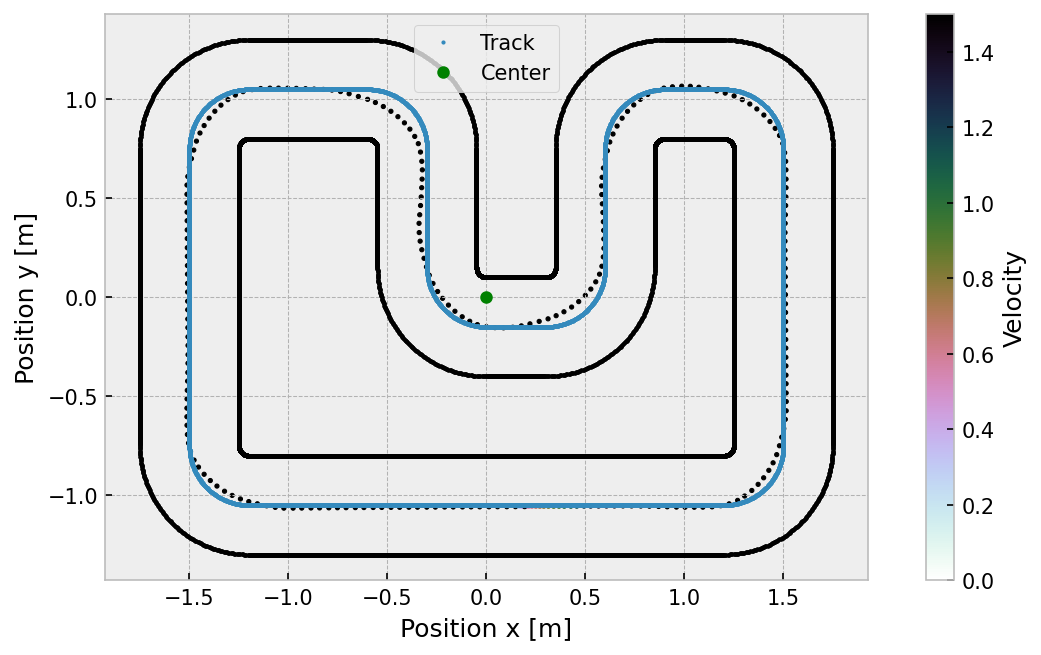

In [16]:
plot_sim(x_full_T.T)

In [34]:
x_H_full.shape

(6, 180)

x_init: 0.15000000000000002
y_init: -1.0499999999999994
yaw_init: 0.0
Total Arc Length: 11.568244517641709


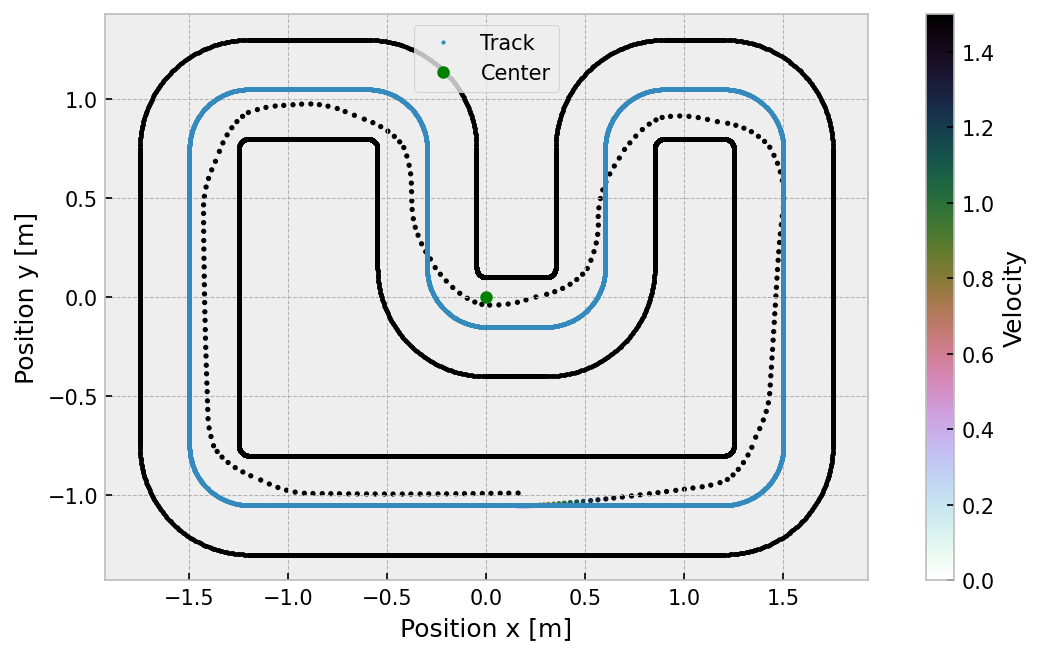

In [17]:
plot_sim(x_H_full.T)

x_init: 0.15000000000000002
y_init: -1.0499999999999994
yaw_init: 0.0
Total Arc Length: 11.568244517641709


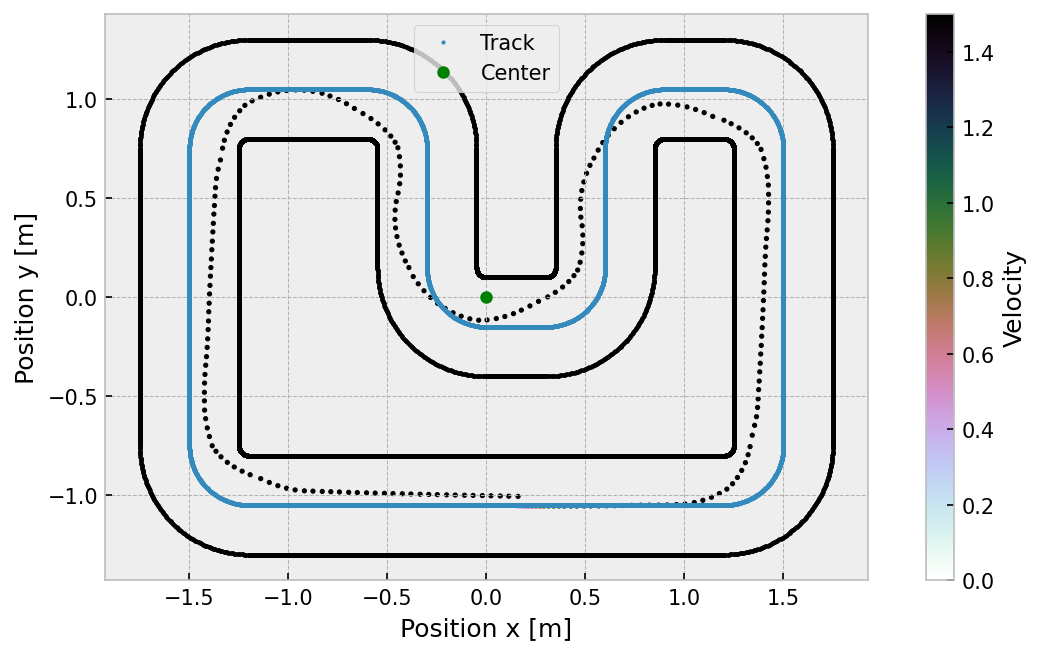

In [18]:
plot_sim(x_full.T)

In [39]:
xy.shape

torch.Size([2])

In [ ]:
x_simulated = (x_pred_full.T)

In [41]:
x_pred_full

NameError: name 'x_pred_full' is not defined